##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Mixed Effects Models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


A linear mixed effects model is a simple approach for modeling structured linear relationships (Harville, 1997; Laird and Ware, 1982). Each data point consists of inputs of varying type—categorized into groups—and a real-valued output. A linear mixed effects model is a _hierarchical model_: it shares statistical strength across groups in order to improve inferences about any individual data point.

In this tutorial, we demonstrate linear mixed effects models with a real-world example in TensorFlow Probability. We'll use the Edward2 (`tfp.edward2`) and Markov Chain Monte Carlo (`tfp.mcmc`) modules.

In [1]:
!pip install -q tensorflow-probability

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from tensorflow_probability import edward2 as ed

plt.style.use('ggplot')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

We use the `InstEval` data set from the popular [`lme4` package in R](https://CRAN.R-project.org/package=lme4) (Bates et al., 2015). It is a data set of courses and their evaluation ratings. Each course includes metadata such as `students`, `instructors`, and `departments`, and the response variable of interest is the evaluation rating.

In [3]:
def load_insteval():
    """Loads the InstEval data set.

    It contains 73,421 university lecture evaluations by students at ETH
    Zurich with a total of 2,972 students, 2,160 professors and
    lecturers, and several student, lecture, and lecturer attributes.
    Implementation is built from the `observations` Python package.

    Returns:
    Tuple of np.darray `x_train` with 73,421 rows and 7 columns and
    dictionary `metadata` of column headers (feature names).
    """
    url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
    with requests.Session() as s:
        download = s.get(url)
        f = download.content.decode().splitlines()

    iterator = csv.reader(f)
    columns = next(iterator)[1:]
    x_train = np.array([row[1:] for row in iterator], dtype=np.int)
    metadata = {'columns': columns}
    return x_train, metadata

We load and preprocess the data set. We hold out 20% of the data so we can evaluate our fitted model on unseen data points. Below we visualize the first few rows.

In [4]:
data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,students,instructors,studage,lectage,service,departments,ratings
58511,2365,387,2,5,0,2,3
28991,1179,673,4,4,1,10,5
57568,2326,581,8,1,0,3,3
12530,480,720,6,1,0,5,5
68795,2797,938,8,6,1,10,2


We set up the data set in terms of a `features` dictionary of inputs and a `labels` output corresponding to the ratings. Each feature is encoded as an integer and each label (evaluation rating) is encoded as a floating point number.

In [5]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']}
labels_train = get_value(train, key='ratings', dtype=np.float32)

features_test = {k: get_value(test, key=k, dtype=np.int32)
                 for k in ['students', 'instructors', 'departments', 'service']}
labels_test = get_value(test, key='ratings', dtype=np.float32)

In [7]:
num_students = max(features_train['students']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]

print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


## Model

A typical linear model assumes independence, where any pair of data points has a constant linear relationship. In the `InstEval` data set, observations arise in groups each of which may have varying slopes and intercepts. Linear mixed effects models, also known as hierarchical linear models or multilevel linear models, capture this phenomenon (Gelman & Hill, 2006).

Examples of this phenomenon include:

+ __Students__. Observations from a student are not independent: some students may systematically give low (or high) lecture ratings.
+ __Instructors__. Observations from an instructor are not independent: we expect good teachers to generally have good ratings and bad teachers to generally have bad ratings.
+ __Departments__. Observations from a department are not independent: certain departments may generally have dry material or stricter grading and thus be rated lower than others.

To capture this, recall that for a data set of $N\times D$ features $\mathbf{X}$ and $N$ labels $\mathbf{y}$, linear regression posits the model

\begin{equation*}
\mathbf{y} = \mathbf{X}\beta + \alpha + \epsilon,
\end{equation*}

where there is a slope vector $\beta\in\mathbb{R}^D$, intercept $\alpha\in\mathbb{R}$, and random noise $\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$. We say that $\beta$ and $\alpha$ are "fixed effects": they are effects held constant across the population of data points $(x, y)$. An equivalent formulation of the equation as a likelihood is $\mathbf{y} \sim \text{Normal}(\mathbf{X}\beta + \alpha, \mathbf{I})$. This likelihood is maximized during inference in order to find point estimates of $\beta$ and $\alpha$ that fit the data.

A linear mixed effects model extends linear regression as

\begin{align*}
\eta &\sim \text{Normal}(\mathbf{0}, \sigma^2 \mathbf{I}), \\
\mathbf{y} &= \mathbf{X}\beta + \mathbf{Z}\eta + \alpha + \epsilon.
\end{align*}

where there is still a slope vector $\beta\in\mathbb{R}^P$, intercept $\alpha\in\mathbb{R}$, and random noise $\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$. In addition, there is a term $\mathbf{Z}\eta$, where $\mathbf{Z}$ is a features matrix and $\eta\in\mathbb{R}^Q$ is a vector of random slopes; $\eta$ is normally distributed with variance component parameter $\sigma^2$. $\mathbf{Z}$ is formed by partitioning the original $N\times D$ features matrix in terms of a new $N\times P$ matrix $\mathbf{X}$ and $N\times Q$ matrix $\mathbf{Z}$, where $P + Q=D$: this partition allows us to model the features separately using the fixed effects $\beta$ and the latent variable $\eta$ respectively.

We say the latent variables $\eta$ are "random effects": they are effects that vary across the population (although they may be constant across subpopulations). In particular, because the random effects $\eta$ have mean 0, the data label's mean is captured by $\mathbf{X}\beta + \alpha$. The random effects component $\mathbf{Z}\eta$ captures variations in the data: for example, "Instructor \#54 is rated 1.4 points higher than the mean."

In this tutorial, we posit the following effects:

+ Fixed effects: `service`. `service` is a binary covariate corresponding to whether the course belongs to the instructor's main department. No matter how much additional data we collect, it can only take on values $0$ and $1$.
+ Random effects: `students`, `instructors`, and `departments`. Given more observations from the population of course evaluation ratings, we may be looking at new students, teachers, or departments.

In the syntax of R's lme4 package (Bates et al., 2015), the model can be summarized as

```
ratings ~ service + (1|students) + (1|instructors) + (1|departments) + 1
```
where `x` denotes a fixed effect,`(1|x)` denotes a random effect for `x`, and `1` denotes an intercept term.

We implement this model below as an Edward program.

In [10]:
def linear_mixed_effects_model(features):
  # Set up fixed effects and other parameters.
    intercept = tf.get_variable("intercept", [])  # alpha in eq
    
    effect_service = tf.get_variable("effect_service", [])  # beta in eq
    
    stddev_students = tf.exp(
      tf.get_variable("stddev_unconstrained_students", []))  # sigma in eq
    stddev_instructors = tf.exp(
      tf.get_variable("stddev_unconstrained_instructors", [])) # sigma in eq
    stddev_departments = tf.exp(
      tf.get_variable("stddev_unconstrained_departments", [])) # sigma in eq

  # Set up random effects.
    effect_students = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_students),
      scale_identity_multiplier=stddev_students,
      name="effect_students")
    
    effect_instructors = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_instructors),
      scale_identity_multiplier=stddev_instructors,
      name="effect_instructors")
    
    effect_departments = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_departments),
      scale_identity_multiplier=stddev_departments,
      name="effect_departments")

  # Set up likelihood given fixed and random effects.
  # Note we use `tf.gather` instead of matrix-multiplying a design matrix of
  # one-hot vectors. The latter is memory-intensive if there are many groups.
    ratings = ed.Normal(
        loc=(effect_service * features["service"] +
           tf.gather(effect_students, features["students"]) +
           tf.gather(effect_instructors, features["instructors"]) +
           tf.gather(effect_departments, features["departments"]) +
           intercept),
      scale=1.,
      name="ratings")  
    return ratings

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", linear_mixed_effects_model)

As an Edward program, we can also visualize the model's structure in terms of its computational graph. This graph encodes dataflow across the random variables in the program, making explicit their relationships in terms of a graphical model (Jordan, 2003).

As a statistical tool, we might look at the graph in order to better see, for example, that `intercept` and `effect_service` are conditionally dependent given `ratings`; this may be harder to see from the source code if the program is written with classes, cross references across modules, and/or subroutines. As a computational tool, we might also notice latent variables flow into the `ratings` variable via `tf.gather` ops. This may be a bottleneck on certain hardware accelerators if indexing `Tensor`s is expensive; visualizing the graph makes this readily apparent.


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
        if size > max_const_size:
            tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def draw_graph(model, *args, **kwargs):
    """Visualize TensorFlow graph."""
    graph = tf.Graph()
    with graph.as_default():
        model(*args, **kwargs)
        graph_def = graph.as_graph_def()
        strip_def = strip_consts(graph_def, max_const_size=32)
        code = """
          <script>
            function load() {{
              document.getElementById("{id}").pbtxt = {data};
            }}
          </script>
          <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
          <div style="height:600px">
            <tf-graph-basic id="{id}"></tf-graph-basic>
          </div>
        """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

        iframe = """
          <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
        """.format(code.replace('"', '&quot;'))
        IPython.display.display(IPython.display.HTML(iframe))


draw_graph(linear_mixed_effects_model, features_train)

## Parameter Estimation

Given data, the goal of inference is to fit the model's fixed effects slope $\beta$, intercept $\alpha$, and variance component parameter $\sigma^2$. The maximum likelihood principle formalizes this task as

$$
\max_{\beta, \alpha, \sigma}~\log p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}; \beta, \alpha, \sigma) = \max_{\beta, \alpha, \sigma}~\log \int p(\eta; \sigma) ~p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}, \eta; \beta, \alpha)~d\eta.
$$

In this tutorial, we use the Monte Carlo EM algorithm to maximize this marginal density (Dempster et al., 1977; Wei and Tanner, 1990).¹ We perform Markov chain Monte Carlo to compute the expectation of the conditional likelihood with respect to the random effects ("E-step"), and we perform gradient descent to maximize the expectation with respect to the parameters ("M-step"):

+ For the E-step, we set up Hamiltonian Monte Carlo (HMC). It takes a current state—the student, instructor, and department effects—and returns a new state. We assign the new state to TensorFlow variables, which will denote the state of the HMC chain.

+ For the M-step, we use the posterior sample from HMC to calculate an unbiased estimate of the marginal likelihood up to a constant. We then apply its gradient with respect to the parameters of interest. This produces an unbiased stochastic descent step on the marginal likelihood. We implement it with the Adam TensorFlow optimizer and minimize the negative of the marginal.

In [16]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(effect_students, effect_instructors, effect_departments):
    """Unnormalized target density as a function of states."""
    return log_joint(  # fix `features` and `ratings` to the training data
        features=features_train,
        effect_students=effect_students,
        effect_instructors=effect_instructors,
        effect_departments=effect_departments,
        ratings=labels_train)

tf.reset_default_graph()

# Set up E-step (MCMC).
effect_students = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_students", [num_students], trainable=False)
effect_instructors = tf.get_variable(
    "effect_instructors", [num_instructors], trainable=False)
effect_departments = tf.get_variable(
    "effect_departments", [num_departments], trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)

current_state = [effect_students, effect_instructors, effect_departments]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

expectation_update = tf.group(
    effect_students.assign(next_state[0]),
    effect_instructors.assign(next_state[1]),
    effect_departments.assign(next_state[2]))

# Set up M-step (gradient descent).
# The following should work. However, TensorFlow raises an error about taking
# gradients through IndexedSlices tensors. This may be a TF bug. For now,
# we recompute the target's log probability at the current state.
# loss = -kernel_results.accepted_results.target_log_prob
with tf.control_dependencies([expectation_update]):
    loss = -target_log_prob_fn(effect_students,
                             effect_instructors,
                             effect_departments)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    minimization_update = optimizer.minimize(loss)

We perform a warm-up stage, which runs one MCMC chain for a number of iterations so that training may be initialized within the posterior's probability mass. We then run a training loop. It jointly runs the E and M-steps and records values during training.

In [26]:
init = tf.global_variables_initializer()

num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)

# Run warm-up stage.
for t in range(num_warmup_iters):
    _, is_accepted_val = sess.run(
      [expectation_update, kernel_results.is_accepted])
    num_accepted += is_accepted_val
    if t % 500 == 0 or t == num_warmup_iters - 1:
        print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
            t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
    for _ in range(5):  # run 5 MCMC iterations before every joint EM update
        _ = sess.run(expectation_update)
        [
          _,
          _,
          effect_students_val,
          effect_instructors_val,
          effect_departments_val,
          is_accepted_val,
          loss_val,
          ] = sess.run([
              expectation_update,
              minimization_update,
              effect_students,
              effect_instructors,
              effect_departments,
              kernel_results.is_accepted,
              loss,
      ])
    effect_students_samples[t, :] = effect_students_val
    effect_instructors_samples[t, :] = effect_instructors_val
    effect_departments_samples[t, :] = effect_departments_val
    num_accepted += is_accepted_val
    loss_history[t] = loss_val
    if t % 500 == 0 or t == num_iters - 1:
        print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(t, num_accepted / (t + 1), loss_val))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.741
Warm-Up Iteration: 999 Acceptance Rate: 0.719
Iteration:    0 Acceptance Rate: 0.000 Loss: 96817.578
Iteration:  500 Acceptance Rate: 0.663 Loss: 96102.227
Iteration: 1000 Acceptance Rate: 0.677 Loss: 96066.109
Iteration: 1499 Acceptance Rate: 0.679 Loss: 96106.906


Above, we did not run the algorithm until a convergence threshold was detected. To check whether training was sensible, we verify that the loss function indeed tends to converge over training iterations.

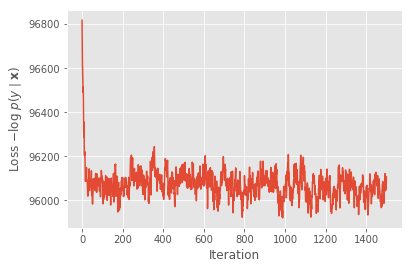

In [27]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

We also use a trace plot, which shows the Markov chain Monte Carlo algorithm's trajectory across specific latent dimensions. Below we see that specific instructor effects indeed meaningfully transition away from their initial state and explore the state space. The trace plot also indicates that the effects differ across instructors but with similar mixing behavior.

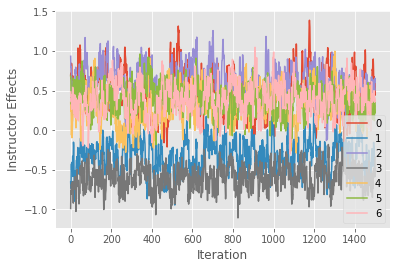

In [29]:
for i in range(7):
    plt.plot(effect_instructors_samples[:, i])

plt.legend([i for i in range(7)], loc='lower right')
plt.ylabel('Instructor Effects')
plt.xlabel('Iteration')
plt.show()

## Criticism

Above, we fitted the model. We now look into criticizing its fit using data, which lets us explore and better understand the model. One such technique is a residual plot, which plots the difference between the model's predictions and ground truth for each data point. If the model were correct, then their difference should be standard normally distributed; any deviations from this pattern in the plot indicate model misfit.

We build the residual plot by first forming the posterior predictive distribution over ratings, which replaces the prior distribution on the random effects with its posterior given training data. In particular, we run the model forward and intercept its dependence on prior random effects with their inferred posterior means.²

In [31]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
    """Replaces prior on effects with empirical posterior mean from MCMC."""
    name = rv_kwargs.pop("name")
    if name == "effect_students":
        rv_kwargs["value"] = np.mean(effect_students_samples, 0)
    elif name == "effect_instructors":
        rv_kwargs["value"] = np.mean(effect_instructors_samples, 0)
    elif name == "effect_departments":
        rv_kwargs["value"] = np.mean(effect_departments_samples, 0)
    return rv_constructor(*rv_args, **rv_kwargs)

with ed.interception(interceptor):
    ratings_posterior = model_template(features=features_test)

ratings_prediction = ratings_posterior.distribution.mean()

Upon visual inspection, the residuals look somewhat standard-normally distributed. However, the fit is not perfect: there is larger probability mass in the tails than a normal distribution, which indicates the model might improve its fit by relaxing its normality assumptions.

In particular, although it is most common to use a normal distribution to model ratings in the `InstEval` data set, a closer look at the data reveals that course evaluation ratings are in fact ordinal values from 1 to 5. This suggests that we should be using an ordinal distribution, or even Categorical if we have enough data to throw away the relative ordering. This is a one-line change to the Edward program above; the same inference code is applicable.

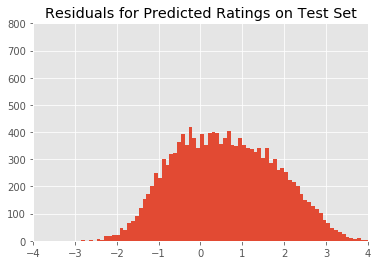

In [33]:
ratings_pred = sess.run(ratings_prediction)
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_pred - labels_test, 75)
plt.show()

To explore how the model makes individual predictions, we look at the histogram of effects for students, instructors, and departments. This lets us understand how individual elements in a data point's feature vector tends to influence the outcome.

Not surprisingly, we see below that each student typically has little effect on an instructor's evaluation rating. Interestingly, we see that the department an instructor belongs to has a large effect.

In [34]:
[
    effect_students_mean,
    effect_instructors_mean,
    effect_departments_mean,
] = sess.run([
    tf.reduce_mean(effect_students_samples, 0),
    tf.reduce_mean(effect_instructors_samples, 0),
    tf.reduce_mean(effect_departments_samples, 0),
])

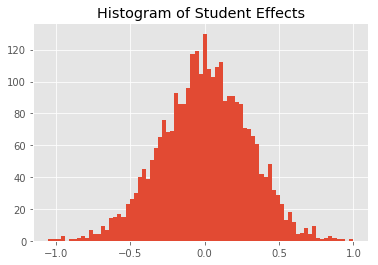

In [35]:
plt.title("Histogram of Student Effects")
plt.hist(effect_students_mean, 75)
plt.show()

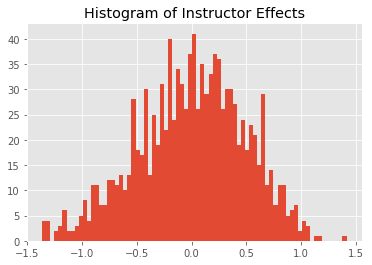

In [36]:
plt.title("Histogram of Instructor Effects")
plt.hist(effect_instructors_mean, 75)
plt.show()

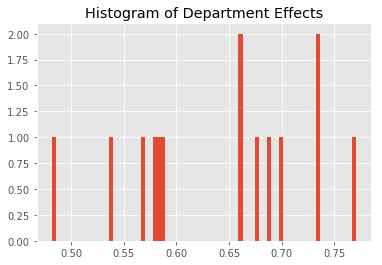

In [37]:
plt.title("Histogram of Department Effects")
plt.hist(effect_departments_mean, 75)
plt.show()

## Footnotes

¹ Linear mixed effect models are a special case where we can analytically compute its marginal density. For the purposes of this tutorial, we demonstrate Monte Carlo EM, which more readily applies to non-analytic marginal densities such as if the likelihood were extended to be Categorical instead of Normal.

² For simplicity, we form the predictive distribution's mean using only one forward pass of the model. This is done by conditioning on the posterior mean and is valid for linear mixed effects models. However, this is not valid in general: the posterior predictive distribution's mean is typically intractable and requires taking the empirical mean across multiple forward passes of the model given posterior samples.

## Acknowledgments

This tutorial was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/linear_mixed_effects_models.ipynb)). We thank all contributors to writing and revising that version.

## References

1. Douglas Bates and Martin Machler and Ben Bolker and Steve Walker. Fitting Linear Mixed-Effects Models Using lme4. _Journal of Statistical Software_, 67(1):1-48, 2015.

2. Arthur P. Dempster, Nan M. Laird, and Donald B. Rubin. Maximum likelihood from incomplete data via the EM algorithm. _Journal of the Royal Statistical Society, Series B (Methodological)_, 1-38, 1977.

3. Andrew Gelman and Jennifer Hill. _Data analysis using regression and multilevel/hierarchical models._ Cambridge University Press, 2006.

4. David A. Harville. Maximum likelihood approaches to variance component estimation and to related problems. _Journal of the American Statistical Association_, 72(358):320-338, 1977.

5. Michael I. Jordan. An Introduction to Graphical Models. Technical Report, 2003.

6. Nan M. Laird and James Ware. Random-effects models for longitudinal data. _Biometrics_, 963-974, 1982.

7. Greg Wei and Martin A. Tanner. A Monte Carlo implementation of the EM algorithm and the poor man's data augmentation algorithms. _Journal of the American Statistical Association_, 699-704, 1990.